In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import re
from sklearn import preprocessing
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import pad_sequences
from tensorflow.python.client import device_lib
from keras.constraints import maxnorm
from keras.layers import Dropout
import time
import nltk
import warnings
warnings.filterwarnings("ignore")


In [79]:
df = pd.read_excel("C:/Users/jllce/Downloads/classificacao_assuntos.xlsx")

In [80]:
df.isnull().sum()

tweets    0
label     0
dtype: int64

In [81]:
# Se tiver valores nulos, usar o código abaixo

# df = df[~df['label'].isnull()]
# df

In [82]:
df["label"].value_counts()

Outro          8385
Entrega        4819
Produto        2961
Atendimento    1944
Name: label, dtype: int64

In [83]:
df["label"].value_counts(normalize=True)

Outro          0.463029
Entrega        0.266111
Produto        0.163510
Atendimento    0.107350
Name: label, dtype: float64

In [84]:
dfO = df[df["label"] == "Outro"].sample(frac = 0.25)
dfE = df[df["label"] == "Entrega"].sample(frac = 0.45)
dfP = df[df["label"] == "Produto"].sample(frac = 0.70)

df = pd.concat([dfO, dfE, dfP, df[df["label"] == "Atendimento"]])
df["label"].value_counts()

Entrega        2169
Outro          2096
Produto        2073
Atendimento    1944
Name: label, dtype: int64

In [85]:

df["label"].value_counts(normalize=True)

Entrega        0.261893
Outro          0.253079
Produto        0.250302
Atendimento    0.234726
Name: label, dtype: float64

In [86]:
df1 = df["tweets"]
df2 = df["label"]

In [87]:
def cleanTxt(text):
  import re
  text = text.lower()
  text = re.sub(r"@([a-zA-Z0-9_]{1,50})",'',str(text)) 
  text = re.sub(r'(?:\@|https?\://)\S+','',text)
  text = re.sub(r'\d+','', text)
  text = re.sub(r"[-()\"#/;:<>{}-~=|.?,]","",text)
  return text

def removeEmojis(text):
  emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002500-\U00002BEF"
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"
        u"\u3030"
        "]+", re.UNICODE)
  text = emoji_pattern.sub(r'', text)
  return text

def removeStopWords(text):
    stemmer = nltk.stem.RSLPStemmer()
    stopwords = set(nltk.corpus.stopwords.words('portuguese'))
    words = [stemmer.stem(i) for i in text.split() if not i in stopwords]
    return (" ".join(words))


tweets_tratados = df1.apply(cleanTxt)
tweets_tratados = tweets_tratados.apply(removeEmojis)
tweets_tratados = tweets_tratados.apply(removeStopWords)
tweets = list(tweets_tratados)

In [88]:
#Verificando novamente se houve tweets nulos após tratamento
tweets_tratados.isnull().sum()

0

In [89]:
label_encoder = preprocessing.LabelEncoder()
labels = pd.DataFrame(label_encoder.fit_transform(df2), columns=["Label"], index = df.index)
labels

,Label
1002,2
15675,2
17453,2
15746,2
3094,2
...,...
18077,0
18081,0
18102,0
18103,0


In [90]:
labels.value_counts()

Label
1        2169
2        2096
3        2073
0        1944
dtype: int64

In [91]:
from keras.utils.np_utils import to_categorical
y = to_categorical(labels)

In [92]:
y.shape

(8282, 4)

In [93]:
# preparar tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets)

In [94]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 7825 unique tokens.


In [95]:
# integer codificar os documentos
sequences = tokenizer.texts_to_sequences(tweets)

In [96]:
# preencher documentos com um comprimento máximo de 28 palavras
maxlen = 28
X = pad_sequences(sequences, maxlen=maxlen)

In [97]:
X.shape

(8282, 28)

In [98]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [99]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5797, 28), (2485, 28), (5797, 4), (2485, 4))

In [100]:
# SimpleRNN
vocab_size = len(word_index) + 1
output_dim = 32
maxlen = maxlen
model = Sequential()
model.add(Embedding(vocab_size, output_dim, input_length = maxlen, embeddings_constraint=maxnorm(3)))
model.add(SimpleRNN(output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(SimpleRNN(output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(SimpleRNN(output_dim))
model.add(Dense(4,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [101]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 28, 32)            250432    
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 28, 32)            2080      
                                                                 
 dropout_4 (Dropout)         (None, 28, 32)            0         
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 28, 32)            2080      
                                                                 
 dropout_5 (Dropout)         (None, 28, 32)            0         
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 4)                

In [102]:
model.save('srnn.h5')

In [103]:
start = time.time()

# Ajustar o modelo ao conjunto de treino
rnn_hist = model.fit(X_train, y_train, epochs=10, validation_split=0.3)
# Avaliação final do modelo
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
warnings.filterwarnings("ignore")

end = time.time()
total = (end-start)/60
print('Training duration(minutes): {}'.format(total))

Epoch 1/10
127/127 [==============================] - 9s 31ms/step - loss: 1.3120 - accuracy: 0.3749 - val_loss: 1.2219 - val_accuracy: 0.4695
Epoch 2/10
127/127 [==============================] - 3s 26ms/step - loss: 0.9251 - accuracy: 0.6308 - val_loss: 1.0139 - val_accuracy: 0.5885
Epoch 3/10
127/127 [==============================] - 3s 26ms/step - loss: 0.4987 - accuracy: 0.8351 - val_loss: 0.9783 - val_accuracy: 0.6540
Epoch 4/10
127/127 [==============================] - 3s 24ms/step - loss: 0.2705 - accuracy: 0.9150 - val_loss: 1.0574 - val_accuracy: 0.6621
Epoch 5/10
127/127 [==============================] - 3s 26ms/step - loss: 0.1553 - accuracy: 0.9556 - val_loss: 1.1875 - val_accuracy: 0.6557
Epoch 6/10
127/127 [==============================] - 3s 26ms/step - loss: 0.1022 - accuracy: 0.9736 - val_loss: 1.2631 - val_accuracy: 0.6517
Epoch 7/10
127/127 [==============================] - 4s 31ms/step - loss: 0.0874 - accuracy: 0.9766 - val_loss: 1.4461 - val_accuracy: 0.6201

In [104]:
model = Sequential()
model.add(Embedding(vocab_size,output_dim, input_length = maxlen, embeddings_constraint=maxnorm(3)))
model.add(LSTM(output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(LSTM(output_dim, return_sequences=True, kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(LSTM(output_dim, kernel_constraint=maxnorm(3)))
model.add(Dense(4,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
warnings.filterwarnings("ignore")

In [105]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 28, 32)            250432    
                                                                 
 lstm_3 (LSTM)               (None, 28, 32)            8320      
                                                                 
 dropout_6 (Dropout)         (None, 28, 32)            0         
                                                                 
 lstm_4 (LSTM)               (None, 28, 32)            8320      
                                                                 
 dropout_7 (Dropout)         (None, 28, 32)            0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320      
                                                                 
 dense_3 (Dense)             (None, 4)                

In [106]:
model.save('lstm.h5')

In [107]:
start = time.time()
# Ajustar o modelo ao conjunto de treino
lstm_hist = model.fit(X_train, y_train, epochs=10, validation_split=0.3)
# avaliação final do modelo
warnings.filterwarnings("ignore")
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
warnings.filterwarnings("ignore")
end = time.time()
total = (end-start)/60
print('Training duration(minutes): {}'.format(total))

Epoch 1/10
127/127 [==============================] - 14s 56ms/step - loss: 1.2594 - accuracy: 0.4060 - val_loss: 1.1174 - val_accuracy: 0.5310
Epoch 2/10
127/127 [==============================] - 7s 52ms/step - loss: 0.8633 - accuracy: 0.6667 - val_loss: 0.8902 - val_accuracy: 0.6603
Epoch 3/10
127/127 [==============================] - 6s 51ms/step - loss: 0.5687 - accuracy: 0.7962 - val_loss: 0.8333 - val_accuracy: 0.7000
Epoch 4/10
127/127 [==============================] - 7s 52ms/step - loss: 0.3827 - accuracy: 0.8780 - val_loss: 0.8548 - val_accuracy: 0.7075
Epoch 5/10
127/127 [==============================] - 6s 48ms/step - loss: 0.2725 - accuracy: 0.9187 - val_loss: 0.9910 - val_accuracy: 0.7103
Epoch 6/10
127/127 [==============================] - 6s 48ms/step - loss: 0.2013 - accuracy: 0.9384 - val_loss: 1.0995 - val_accuracy: 0.6954
Epoch 7/10
127/127 [==============================] - 6s 48ms/step - loss: 0.1737 - accuracy: 0.9502 - val_loss: 1.1325 - val_accuracy: 0.703

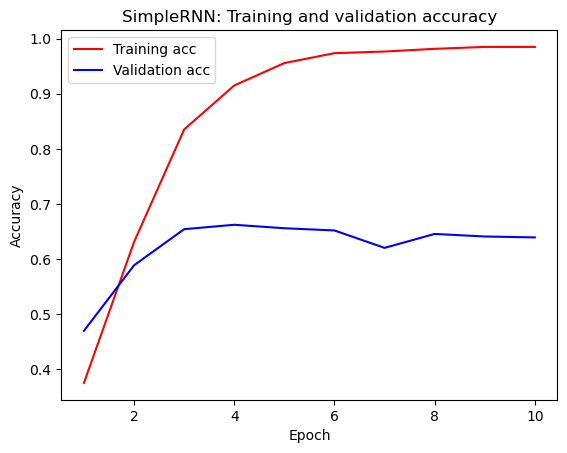

In [108]:
# SimpleRNN Result

acc = rnn_hist.history['accuracy']
val_acc = rnn_hist.history['val_accuracy']
loss = rnn_hist.history['loss']
val_loss = rnn_hist.history['val_loss']
epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('SimpleRNN: Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

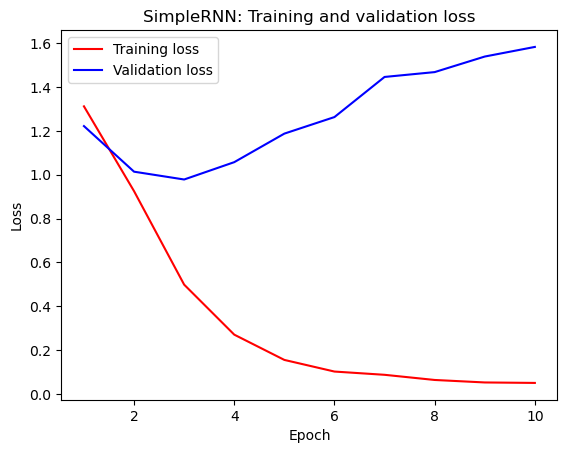

In [109]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('SimpleRNN: Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

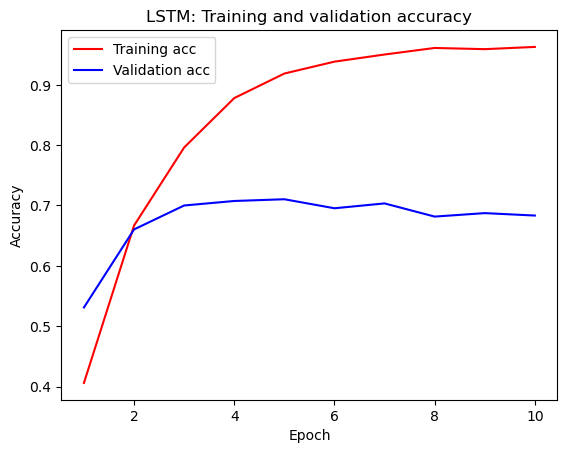

In [110]:
# LSTM Result

acc = lstm_hist.history['accuracy']
val_acc = lstm_hist.history['val_accuracy']
loss = lstm_hist.history['loss']
val_loss = lstm_hist.history['val_loss']
epochs = range(1, len(acc)+1)
_ = plt.plot(epochs, acc, 'r', label='Training acc')
_ = plt.plot(epochs, val_acc, 'b', label='Validation acc')
_ = plt.title('LSTM: Training and validation accuracy')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Accuracy')
_ = plt.legend(loc='best')
plt.show()

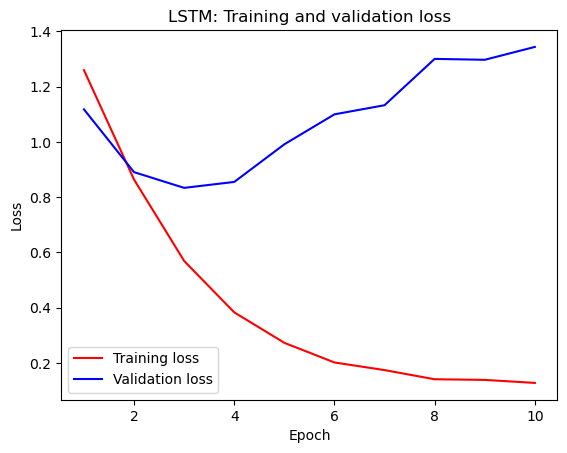

In [111]:
_ = plt.plot(epochs, loss, 'r', label='Training loss')
_ = plt.plot(epochs, val_loss, 'b', label='Validation loss')
_ = plt.title('LSTM: Training and validation loss')
_ = plt.xlabel('Epoch')
_ = plt.ylabel('Loss')
_ = plt.legend(loc='best')
plt.show()

In [112]:
from keras.models import load_model
lstm = load_model('lstm.h5')
warnings.filterwarnings("ignore")

In [113]:
lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 28, 32)            250432    
                                                                 
 lstm_3 (LSTM)               (None, 28, 32)            8320      
                                                                 
 dropout_6 (Dropout)         (None, 28, 32)            0         
                                                                 
 lstm_4 (LSTM)               (None, 28, 32)            8320      
                                                                 
 dropout_7 (Dropout)         (None, 28, 32)            0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320      
                                                                 
 dense_3 (Dense)             (None, 4)                

In [114]:
predictions = lstm.predict(X_test)

78/78 [==============================] - 3s 11ms/step
